<center><img src="https://matematica.usm.cl/wp-content/themes/dmatUSM/assets/img/logoDMAT2.png" title="Title text" width= 800 /></center>
<hr style="height:2px;border:none"/>
<h1 align='center'> Ayudantía 7: Modelos de clasificación, librería scikit-learn</h1>

<H3 align='center'> MAT281 2023-2 </H3>

<H3 align='center'> Ayud. Alejandro Villazón G. </H3>
<hr style="height:2px;border:none"/>

Los modelos de regresión asumen que la variable de respuesta es cuantitativa, sin embargo, en muchas situaciones esta variable es cualitativa/categórica, por ejemplo el color de ojos. La idea de predecir variables categóricas es usualmente nombrada como _Clasificación_. Muchos de los problemas en los que se enfoca el Machine Learning están dentro de esta categoría, por lo mismo como vieron en clases existen una serie de algoritmos y modelos con tal de obtener los mejores resultados. 

Todos los modelos vistos en clases se encuentran en la librería `sklearn` y la forma de usarlos es muy similar, es por esto que en esta ayudantía introduciremos el algoritmo de clasificación más sencillo: _Regresión Logística_, y uno de los más intuitivos de comprender: _K Nearest Neighbours_.

Trabajaremos con el conjunto de datos `Breast Cancer`, donde el objetivo es clasificar, en bases a sus características, si un tumor es Benigno o Maligno.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dict = datasets.load_breast_cancer()
breast_cancer = pd.DataFrame(data=data_dict.data,
                    columns=data_dict.feature_names)

breast_cancer['target'] = data_dict.target

breast_cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


`Scikit-learn` tiene su propia implementación de Regresión Logística, para un enfoque más estadístico te invito a revisar la implementación del paquete `statsmodels`. A medida que vayas leyendo e interiorizándote en la librería verás que tratan de mantener una sintaxis consistente en los distintos objetos y métodos.

In [3]:
from sklearn.linear_model import LogisticRegression

In [4]:
X = breast_cancer.drop('target', axis=1)
y = breast_cancer['target']


Logit = LogisticRegression(
    penalty='l2',
    max_iter=10_000
)
Logit.fit(X, y)

LogisticRegression(max_iter=10000)

Podemos obtener los coeficientes resultantes del ajuste a nuestros datos:

In [5]:
Logit.intercept_

array([27.86225018])

In [6]:
Logit.coef_

array([[ 1.02463481,  0.18938939, -0.2752371 ,  0.0222035 , -0.18748759,
        -0.2211678 , -0.54977427, -0.31097222, -0.27576336, -0.02982749,
        -0.08001823,  1.33063912,  0.1189986 , -0.11046714, -0.02689117,
         0.07948469, -0.02621867, -0.03968091, -0.03454673,  0.01621682,
         0.12979387, -0.44559612, -0.10244875, -0.01345003, -0.37655519,
        -0.69246441, -1.46271148, -0.63588321, -0.75073411, -0.0945725 ]])

Podemos predecir según el modelo entrenado:

In [7]:
y_pred_train = Logit.predict(X)
y_pred_train[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0])

Después de entrenar el modelo, es esencial llevar a cabo una evaluación de desempeño adecuada. Sin embargo, no resulta objetivo evaluar el rendimiento del modelo utilizando los mismos datos que se utilizaron para entrenarlo. Por lo tanto, se hace necesario dividir el conjunto de datos en dos partes: el conjunto de entrenamiento (Train Set) y el conjunto de prueba (Test Set). El Test Set se utiliza exclusivamente para evaluar el rendimiento del modelo final previamente seleccionado, sin involucrarse en la selección de hiperparámetros, como la elección de la norma de penalización, que puede ser $\ell_1$, $\ell_2$, o una combinación de ambas.

Para ajustar y optimizar los hiperparámetros, se emplea un tercer conjunto llamado Validation Set, que se obtiene al separar una parte del conjunto de entrenamiento. Este conjunto se utiliza para evaluar el desempeño de diferentes modelos comparables que pertenecen a la misma categoría. Por ejemplo, si se busca comparar los siguientes modelos:
``` python 
- LogisticRegression(penalty='l2')
```
``` python
- LogisticRegression(penalty='elasticnet', l1_ratio=0.6)
```
debemos usar el Validation Set. En cambio, si quiero comparar modelos de diferentes categorías como los siguientes:
``` python 
- LogisticRegression(penalty='l1')
```
``` python 
- DecisionTreeClassifier(max_depth=5, min_samples_leaf=10)
```
debemos usar el Test Set. Es esencial conocer la diferencia entre estos conjuntos de datos, te invito a investigar por tu cuenta [[Articulo]](https://www.geeksforgeeks.org/training-vs-testing-vs-validation-sets/)[[Foro]](https://stats.stackexchange.com/questions/19048/what-is-the-difference-between-test-set-and-validation-set).

Entonces dada la discusión anterior, si queremos ver que tan bueno es nuestro modelo, podemos ajustarlo con parte de los datos (Train Set) y ver que tan bueno es (con alguna métrica) con el resto de los datos (Test Set).

La siguiente función nos permite separar los datos:

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Para el proceso de [_hyperparameter tuning_](https://www.geeksforgeeks.org/hyperparameter-tuning/) podemos utilizar la función [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) de sklearn la que además nos permite realizar Validación Cruzada (lo que nos genera el Validation Set).

In [10]:
from sklearn.model_selection import GridSearchCV

Si queremos buscar los mejores hiperparámetros de un modelo, debemos generar una o más grillas con los valores a tomar por cada hiperparámetro, para que `GridSearchCV` entrene el modelo con todas las combinaciones y luego según una métrica de evaluación entregada por nosotros nos retorne el mejor modelo.

Por ejemplo, veamos los hiperparámetros por defecto de una Regresión Logística de sklearn:

In [11]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [12]:
param_grid = [
    # El nombre de las keys debe ser exactamente el nombre del argumento que recibe el modelo
    {'penalty': ['l1', 'l2']},
    {'penalty' : ['elasticnet'],
     'l1_ratio': [0.2, 0.5, 0.8]
    }
]

logit = LogisticRegression(solver='saga')
 
best_logit = GridSearchCV(logit, param_grid,
                          scoring = 'f1',
                          cv = 5 # Divisiones del conjunto de entrenamiento para generar conjuntos de Validación
                          )
 
best_logit.fit(X, y)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='saga'),
             param_grid=[{'penalty': ['l1', 'l2']},
                         {'l1_ratio': [0.2, 0.5, 0.8],
                          'penalty': ['elasticnet']}],
             scoring='f1')

Obtengamos los resultados:

In [13]:
best_logit.best_estimator_

LogisticRegression(penalty='l1', solver='saga')

In [14]:
best_logit.best_params_

{'penalty': 'l1'}

In [15]:
best_logit.best_score_ # Promedio del score en las iteraciones del CV

0.9317815428553263

También podemos recuperar la historia del entrenamiento, como el score que se obtuvo en cada conjunto de validación al realizar la CV.

In [16]:
best_logit.cv_results_

{'mean_fit_time': array([0.04530773, 0.02728772, 0.03942399, 0.03270593, 0.03431883]),
 'std_fit_time': array([0.01764916, 0.0082778 , 0.00781742, 0.01023639, 0.00802382]),
 'mean_score_time': array([0.00628366, 0.00489397, 0.00406032, 0.        , 0.013343  ]),
 'std_score_time': array([0.00317081, 0.00641946, 0.00379608, 0.        , 0.00418524]),
 'param_penalty': masked_array(data=['l1', 'l2', 'elasticnet', 'elasticnet', 'elasticnet'],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_l1_ratio': masked_array(data=[--, --, 0.2, 0.5, 0.8],
              mask=[ True,  True, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'penalty': 'l1'},
  {'penalty': 'l2'},
  {'l1_ratio': 0.2, 'penalty': 'elasticnet'},
  {'l1_ratio': 0.5, 'penalty': 'elasticnet'},
  {'l1_ratio': 0.8, 'penalty': 'elasticnet'}],
 'split0_test_score': array([0.93333333, 0.93333333, 0.93333333, 0.93333333, 0.93333333])

Una vez encontrados los mejores hiperparámetros, se debe entrenar el modelo con todo el conjunto de entrenamiento. Por suerte la función `GridSearchCV` lo realiza por defecto, gracias al parámetro `refit = True`. Por lo que podemos predecir en el Test Set y evaluar el desempeño final del modelo.

In [17]:
y_pred = best_logit.predict(X_test)

Antes de pasar a la evaluación de desempeño, es prudente recordar que la librería `sklearn` es consistente en su sintaxis, por lo que podriamos cambiar el modelo y de forma análoga podremos realizar la clasificación y sus resultados. A continuación se encuentran todos los modelos vistos en clases:

``` python
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingRegressor, BaggingClassifier, RandomForestClassifier
```
¡¡Visita la documentación!!

## Métricas para Clasificación

Sabemos que los modelos de clasificación etiquetan a los datos a partir del entrenamiento. Por lo tanto es necesario introducir conceptos vistos en las cátedras.

Uno de ellos es la matriz de confusión. Típicamente para un clasificador binario (puede ser extendido fácilmente a un problema multiclase) se tiene:

* `TP`: Verdadero Positivo
* `FN`: Falso Negativo
* `FP`: Falso positivo
* `TN`: Verdadero Negativo

En este contexto, los valores `TP` y `TN` muestran los valores correctos que tuve al momento de realizar la predicción, mientras que los valores de de `FN` y `FP` denotan los valores en que la clasificación fue errónea.

Una manera eficaz de visualizar estos resultados es con la _matriz de confusión_

![confusion_matrix](https://miro.medium.com/max/1780/1*LQ1YMKBlbDhH9K6Ujz8QTw.jpeg)

En un principio se busca maximizar la suma de los elementos bien clasificados, sin embargo eso depende mucho del problema a resolver. Para esto se definen las siguientes métricas:

* Accuracy:

    $$\textrm{accuracy}= \frac{TP+TN}{TP+TN+FP+FN}$$
    
* Recall:

    $$\textrm{recall} = \frac{TP}{TP+FN}$$
    
* Precision:

    $$\textrm{precision} = \frac{TP}{TP+FP} $$
    
* F-score:

    $$\textrm{F-score} = 2\times \frac{  \textrm{precision} \times \textrm{recall} }{  \textrm{precision} + \textrm{recall} } $$

Estas son las más comunes, y como te imaginarás, `scikit-learn` tiene toda una artillería de selección de modelos que puedes encontrar en este [enlace](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

La forma usual de visualizar el desempeño de un modelo en un problema de clasificación es a través de la matriz de confusión, para esto se presenta dos formas:

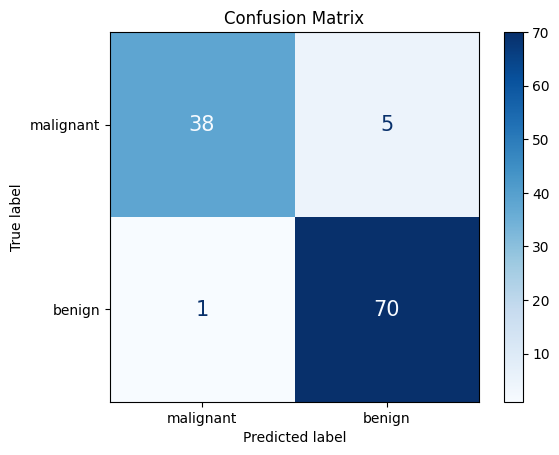

In [19]:
# Utiliza el modelo
ConfusionMatrixDisplay.from_estimator(
    best_logit,
    X_test,
    y_test,
    cmap=plt.cm.Blues,
    display_labels=data_dict.target_names,
    text_kw={'size':15}
)
plt.title('Confusion Matrix');

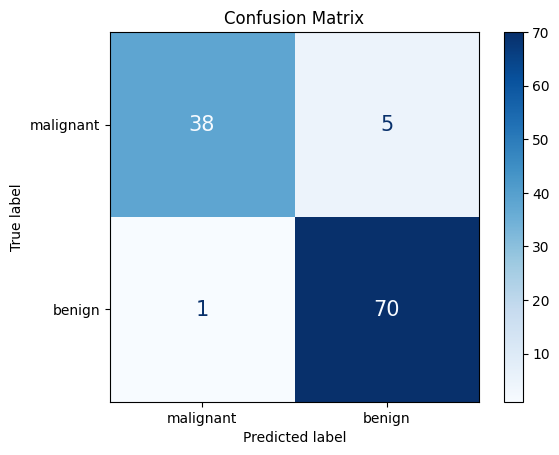

In [20]:
# Utiliza las predicciones
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap=plt.cm.Blues,
    display_labels=data_dict.target_names,
    text_kw={'size':15}
)
plt.title('Confusion Matrix');

El modelo no se ajusta perfectamente como es esperado (si no podríamos caer en _overfitting_), pero te puedes basar en los siguientes resultados para hacer un análisis:

In [21]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

In [22]:
print(f"Accuracy score: {accuracy_score(y_test, y_pred):.3f}")
print(f"Recall score: {recall_score(y_test, y_pred):.3f}")
print(f"F1 score: {f1_score(y_test, y_pred):.3f}")

Accuracy score: 0.947
Recall score: 0.986
F1 score: 0.959


Incluso podemos generar un reporte mucho más rápido. [Más información](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

In [23]:
from sklearn.metrics import classification_report

In [24]:
print(classification_report(y_test, y_pred, target_names=data_dict.target_names))

              precision    recall  f1-score   support

   malignant       0.97      0.88      0.93        43
      benign       0.93      0.99      0.96        71

    accuracy                           0.95       114
   macro avg       0.95      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114



## Curva ROC

Para finalizar te presento como graficar la curva ROC presentada en clases, esto nos da otra forma de escoger un buen clasificador.

Como casi siempre, `scikit-learn` ya tiene implementada la función y mantiene la sintaxis que usamos al generar la matriz de confusión.

In [25]:
from sklearn.metrics import RocCurveDisplay

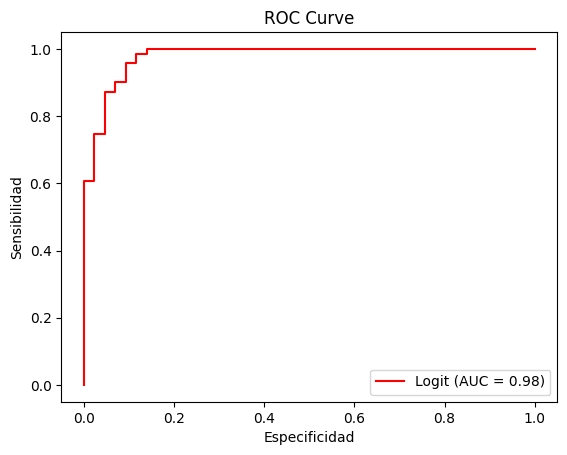

In [26]:
logit_disp = RocCurveDisplay.from_estimator(
    best_logit, 
    X_test, 
    y_test,
    name = 'Logit',
    c='red'
)
plt.xlabel('Especificidad'); plt.ylabel('Sensibilidad')
plt.title('ROC Curve');

Podemos ajustar otros modelos y presentar las curvas en un mismo gráfico!

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

# Esto es solo un ejemplo!
rfc = RandomForestClassifier(n_estimators=100, max_depth=2) 
rfc.fit(X_train, y_train)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

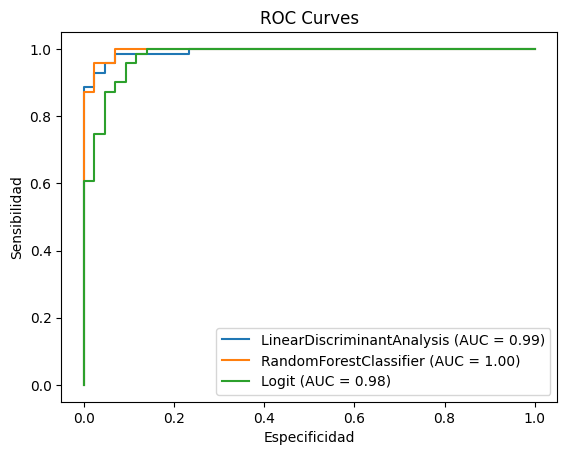

In [28]:
ax = plt.gca() # Get Current Axes
lda_disp = RocCurveDisplay.from_estimator(lda, X_test, y_test, ax=ax)
rfc_disp = RocCurveDisplay.from_estimator(rfc, X_test, y_test, ax=ax)
logit_disp.plot(ax=ax)

plt.xlabel('Especificidad'); plt.ylabel('Sensibilidad')
plt.title('ROC Curves');

Podemos recuperar la AUC:

In [29]:
rfc_disp.roc_auc, logit_disp.roc_auc, lda_disp.roc_auc

(0.9950867998689813, 0.9783819194235178, 0.9924664264657714)

Con esto llegamos al final de los contenidos, te dejo la invitación a que continues estudiando sobre modelos de aprendizaje automático y fortalezcas tus habilidades de programación, visita la página oficial de [`scikit-learn`](https://scikit-learn.org/stable/index.html), ahí podrás encontrar la documentación de los modelos y tutoriales de todo tipo! 

También te invito a que investigues temas más avanzados como redes neuronales, para eso visita la página oficial de [`keras`](https://keras.io/).

# Ejercicio

El conjunto de Dígitos escritos a mano es un ejemplo clásico de conjunto de datos para un problema de clasificación.

Se pide comparar el modelo Support Vector Machine vs K-Nearest Neighbors, para esto separe el conjunto de datos como crea pertinente, realice un _tuning_ a los hiperparámetros, reporte el desempeño de los modelos y justifique cual modelo elegir.

Importamos el conjunto de datos:

In [30]:
digits = datasets.load_digits()

X = digits.data
y = digits.target

print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [31]:
def viz_imgs(imgs, labels):
  "Función para visualizar imágenes junto a sus labels"
  plt.figure(figsize=(10,10))
  random_inds = np.random.choice(imgs.shape[0],36)
  for i, id in enumerate(random_inds):
      plt.subplot(6,6,i+1)
      plt.xticks([]); plt.yticks([]); plt.grid(False)
      plt.imshow(imgs[id], cmap=plt.cm.gray_r, interpolation="nearest")
      plt.xlabel(labels[id])

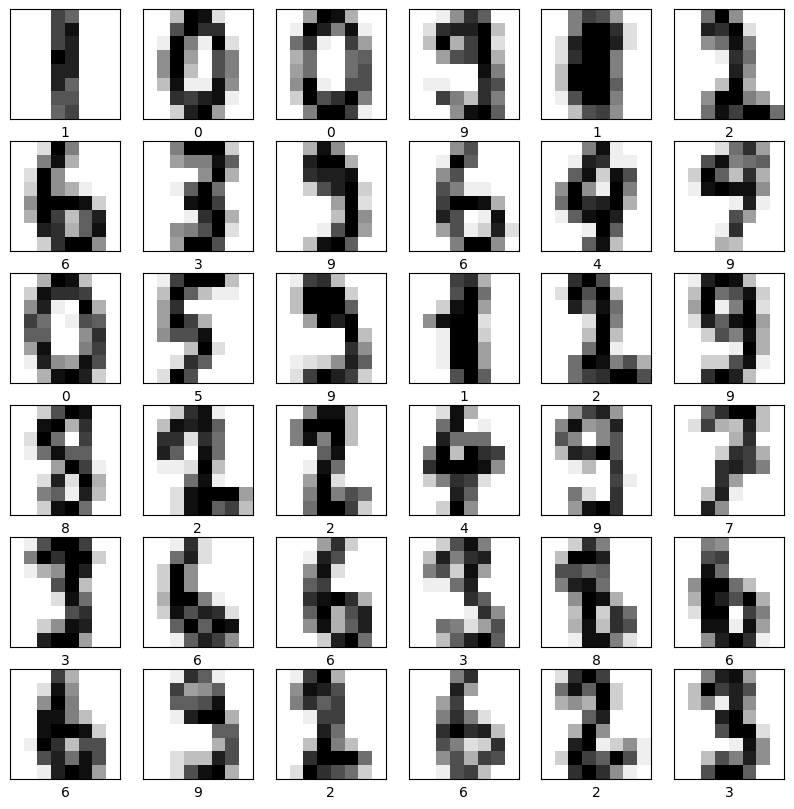

In [32]:
viz_imgs(digits.images, y)

## 1. Separe el conjunto de datos.

In [33]:
# Escribe tu code aquí


## 2. Encuentre los mejores hiperparámetros para cada modelo.

In [34]:
# Escribe tu code aquí


## 3. Reporte el desempeño de los modelos encontrados. Ayudese de matrices de confusión y métricas conocidas. Eliga en base a los anterior el mejor modelo.

In [35]:
# Escribe tu code aquí
